### Import necessary libraries

In [2]:
import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.model_selection import train_test_split

### Read the original data

In [3]:
# Establish a connection to the SQLite database
conn = sqlite3.connect("laliga.sqlite")
#Read into pandas dataframe 
df = pd.read_sql_query("SELECT * FROM Matches", conn)
pd.set_option('display.max_colwidth', None)

## Create the necessary functions to modify the original df and get more relevant parametters

In [4]:
#Creates a new columns with the result of the match
def result_calculator(row):
    if row['home_score'] > row['away_score']:
        return 1
    elif row['home_score'] < row['away_score']:
        return 2
    else:
        return 'X'
        
def process_and_filter_data(input_df):    
    
    # Create a copy of the df, and erase the Nones
    filtered_score_df = input_df[input_df['score'].notna()].copy()
    
    # Split the score to make it easier to read
    split_scores = filtered_score_df['score'].str.split(':', expand=True).astype(int)
    
    # Assign the split scores to new columns
    filtered_score_df['home_score'] = split_scores[0]
    filtered_score_df['away_score'] = split_scores[1]
    filtered_score_df['result'] = filtered_score_df.apply(result_calculator, axis=1)
    return filtered_score_df    

### Obtain set train and set test

In [5]:
def separate_train_test(input_df):
    X = input_df.iloc[:, :-1] 
    y = input_df['result']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

### Separate by teams

In [6]:
def separate_wins_loses_ties(df_filtered):
    df_filtered['Win_local'] = np.where(df_filtered['home_score'] > df_filtered['away_score'], 1, 0)
    df_filtered['Win_away'] = np.where(df_filtered['home_score'] < df_filtered['away_score'], 1, 0)
    df_filtered['Ties'] = np.where(df_filtered['home_score'] == df_filtered['away_score'], 1, 0)
    
    # Combine home and away matches to identify all matches for each team
    df_teams = pd.concat([df_filtered.rename(columns={'home_team': 'team', 'Win_local': 'Win','Win_away':'Lose', 'home_score' : 'GF', 'away_score': 'GA',}),
                             df_filtered.rename(columns={'away_team': 'team', 'Win_away': 'Win','Win_local':'Lose', 'home_score' : 'GA', 'away_score': 'GF'})], ignore_index=True)
    
    return(df_teams)

### Get all information

### Get previous relevant seasons (5 for example) 

In [7]:
def split_season(df):
    df[['date1', 'date2']] = df['season'].str.split('-', expand=True)
    df['date1'] = df['date1'].astype(int)
    df['date2'] = df['date2'].astype(int)
    #df.drop('season', axis=1, inplace=True)
    return df

In [8]:
def process_df_previous_seasons(X_train):
    df_all_summary = separate_wins_loses_ties(X_train) [['season','division','team','GF','GA','Win','Lose','Ties']]
    df_all_summary = df_all_summary.groupby(['season','division','team'])[['GF', 'GA', 'Win', 'Lose', 'Ties']].sum().reset_index()
    df_all_summary['Pts']=3*df_all_summary['Win'] + df_all_summary['Ties']
    df_all_summary['GD'] = df_all_summary['GF'] - df_all_summary['GA']
    df_all_summary = split_season(df_all_summary)
    df_all_summary = df_all_summary[['season','division','team','Pts','GD','date1']]
    return df_all_summary

In [9]:
def process_df_current_season(X_train):
    df_filtered = process_and_filter_data(X_train)


    df_0 = separate_wins_loses_ties(df_filtered) [['season','division','team','GF','GA','Win','Lose','Ties','matchday']]
    df_0 =df_0.sort_values(by=['season','division','matchday'], ascending=[False,True,True])

    df_0['Last'] = df_0['Win']-df_0['Lose']
    grouped = df_0.groupby(['season', 'division', 'team'])
    df_0['GF'] = grouped['GF'].cumsum()
    df_0['GA'] = grouped['GA'].cumsum()
    df_0['Win'] = grouped['Win'].cumsum()
    df_0['Lose'] = grouped['Lose'].cumsum()
    df_0['Ties'] = grouped['Ties'].cumsum()


    df_0['Pts']=3*df_0['Win']+df_0['Ties']
    df_0['GD']=df_0['GF']-df_0['GA']
    df_0 =df_0.sort_values(by=['season','division','matchday','Pts'], ascending=[False,True,False,False])
    order=['season', 'division','team','GF','GA','GD','Win','Lose','Ties','Pts','matchday','Last']
    df_0=df_0[order]
    df_0 = df_0.reset_index()

    df_0 = df_0.drop(columns=['index'])


    for i in range(5):
        df_0[f"last_{i}"] = df_0.groupby(['division','season' ,'team'])['Last'].shift(-i)




    df_0["last_5"] = df_0[[f"last_{i}" for i in range(5)]].agg(lambda x: [i for i in x if not pd.isna(i)],axis=1)

    df_0 = df_0.drop(columns=['Last'])
    for i in range(5):
        df_0 = df_0.drop(columns=[f"last_{i}"])

    df_0['Sum'] = df_0['last_5'].apply(sum)

    df_0['GD']= df_0.groupby(['division','season' ,'team'])['GD'].shift(-1)
    df_0['Pts']= df_0.groupby(['division','season' ,'team'])['Pts'].shift(-1)
    df_0['Sum']= df_0.groupby(['division','season' ,'team'])['Sum'].shift(-1)
    df_0['N'] = df_0['matchday'].apply(lambda x: 1 if x == 0 else 1)
    df_0['GD'] = df_0['N'] * df_0['GD']
    df_0['Pts'] = df_0['N'] * df_0['Pts']
    df_0['Sum'] = df_0['N'] * df_0['Sum']
    df_0.fillna(0, inplace=True)
    df_0=df_0[['season','matchday','team','Pts','Sum','GD']]
    return df_0

In [10]:
def cumsum_n(n):
    return n * (n + 1) // 2

def get_mean_parameter(df_all_summary, team, season, parameter, division):
    season_format = int(season.split('-')[0])
    team_info = df_all_summary[(df_all_summary['team'] == team) & (((season_format-5) <= df_all_summary['date1'])) & (season_format > df_all_summary['date1'])].reset_index()
    
    tam_df = team_info.shape[0]
    
    if tam_df == 0:
        mean_parameter_team = df_all_summary[parameter].mean() # * 0.6
    else:
        team_info['parameter_pondered'] = team_info[parameter] * (team_info.index + 1)
        mean_parameter_team = team_info['parameter_pondered'].sum() / cumsum_n(tam_df)
    
    if division == 2 and parameter == 'Pts':
        mean_parameter_team -= df_all_summary[parameter].mean() * 2
    
    return mean_parameter_team

def get_teams_last_mean_dif_p(row_original, df_all_summary, parameters):
    row = row_original.copy()
    home_team = row['home_team']
    away_team = row['away_team']
    season = row['season']
    division = row['division']

    for parameter in parameters:
        home_mean = get_mean_parameter(df_all_summary, home_team, season, parameter, division)
        away_mean = get_mean_parameter(df_all_summary, away_team, season, parameter, division)
        
        row[f'{parameter}_mean_home'] = home_mean
        row[f'{parameter}_mean_away'] = away_mean
        row[f'dif_{parameter}_mean'] = home_mean - away_mean

    return row



### Get parameters from the same season

In [11]:
def get_matchday_info(row_original, df_0):
    row = row_original.copy()
    home_team = row['home_team']
    away_team = row['away_team']
    season = row['season']
    matchday = row['matchday']

    
    df_0_matchday = df_0[(df_0['season'] == season) & (df_0['matchday'] == matchday)]
    
    home_info = df_0_matchday[df_0_matchday['team'] == home_team].iloc[0]
    away_info = df_0_matchday[df_0_matchday['team'] == away_team].iloc[0]

    row['yet_pts_dif'] = home_info['Pts'] - away_info['Pts']
    row['yet_sum5_dif'] = home_info['Sum'] - away_info['Sum']
    row['yet_GD_dif'] = home_info['GD'] - away_info['GD']

    return row


## Apply everything

In [12]:
df_1 = process_and_filter_data(df)
X_train, X_test, y_train, y_test = separate_train_test(df_1)
df_previous = process_df_previous_seasons(df_1)
df_current = process_df_current_season(df_1)


In [13]:
parameters_to_calculate = ['Pts', 'GD']
def process_X(X_train):
    clean_X_train = X_train[['season','division','matchday','home_team','away_team']]
    X_process_train = clean_X_train.apply(lambda row: get_teams_last_mean_dif_p(row, df_previous, parameters_to_calculate), axis=1)
    X_process_train = X_process_train.apply(lambda row: get_matchday_info(row, df_current), axis=1)
    X_process_train = X_process_train[['dif_GD_mean','dif_Pts_mean','yet_GD_dif','yet_pts_dif','yet_sum5_dif']]
    return X_process_train

In [14]:
X_process_train = process_X(X_train)

In [15]:
X_process_test = process_X(X_test)

In [16]:
y_train_str = y_train.astype(str)
y_test_str = y_test.astype(str)

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

dict_weights = {"1":0.3, "2": 2, "X": 2}

model = RandomForestClassifier(class_weight=dict_weights, n_estimators=100, max_depth=None)
model2 = GradientBoostingClassifier( n_estimators=100, max_depth=3, random_state=42)
clf_NB = GaussianNB()
clf_NB.fit(X_process_train, y_train_str)
model.fit(X_process_train, y_train_str)
model2.fit(X_process_train, y_train_str)

GradientBoostingClassifier(random_state=42)

In [18]:
y_pred = clf_NB.predict(X_process_test)
y_pred_2 = model.predict(X_process_test)
y_pred_3 = model2.predict(X_process_test)

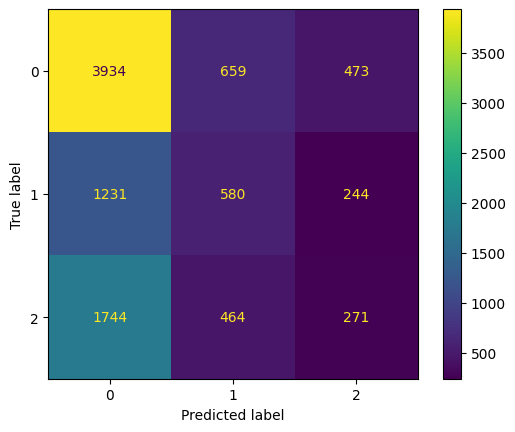

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test_str, y_pred=y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_str, y_pred=y_pred))
print('Precision: %.3f' % precision_score(y_true=y_test_str, y_pred=y_pred, average='micro'))
print('Sensibilidad - Recall: %.3f' % recall_score(y_true=y_test_str, y_pred=y_pred, average='micro'))
print('F1: %.3f' % f1_score(y_true=y_test_str, y_pred=y_pred, average='micro'))

Exactitud - Accuracy: 0.498
Precision: 0.498
Sensibilidad - Recall: 0.498
F1: 0.498


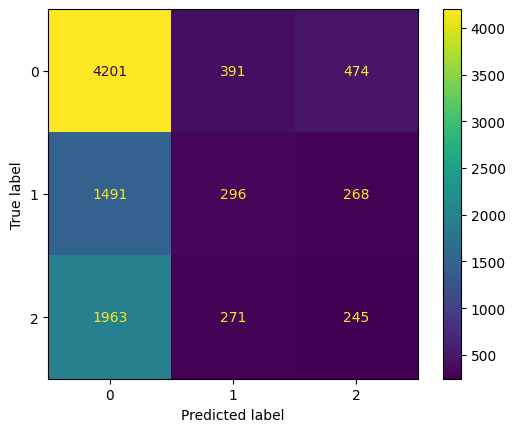

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test_str, y_pred=y_pred_2)
cm_display = ConfusionMatrixDisplay(cm).plot()
np.savetxt('matriztr.csv', X_process_train, delimiter=',', fmt='%d')
np.savetxt('matrizte.csv', X_process_test, delimiter=',', fmt='%d')


In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_str, y_pred=y_pred_2))
print('Precision: %.3f' % precision_score(y_true=y_test_str, y_pred=y_pred_2, average='micro'))
print('Sensibilidad - Recall: %.3f' % recall_score(y_true=y_test_str, y_pred=y_pred_2, average='micro'))
print('F1: %.3f' % f1_score(y_true=y_test_str, y_pred=y_pred_2, average='micro'))

Exactitud - Accuracy: 0.494
Precision: 0.494
Sensibilidad - Recall: 0.494
F1: 0.494


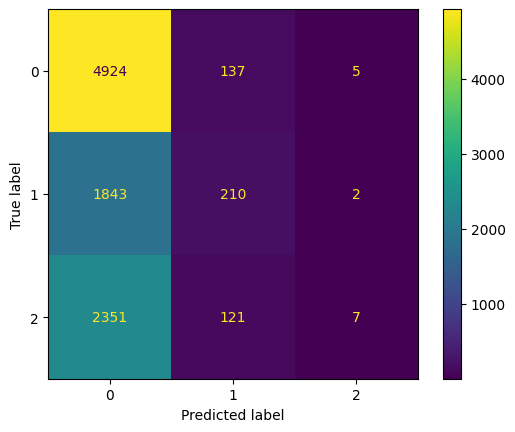

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test_str, y_pred=y_pred_3)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Exactitud - Accuracy: %.3f' % accuracy_score(y_true=y_test_str, y_pred=y_pred_3))
print('Precision: %.3f' % precision_score(y_true=y_test_str, y_pred=y_pred_3, average='micro'))
print('Sensibilidad - Recall: %.3f' % recall_score(y_true=y_test_str, y_pred=y_pred_3, average='micro'))
print('F1: %.3f' % f1_score(y_true=y_test_str, y_pred=y_pred_3, average='micro'))

Exactitud - Accuracy: 0.536


Precision: 0.536
Sensibilidad - Recall: 0.536
F1: 0.536


In [25]:
import joblib

# Ruta donde deseas guardar el modelo
ruta_modelo = 'model.pkl'

# Guardar el modelo
joblib.dump(clf_NB, ruta_modelo)

['model.pkl']